<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista10 - BERT
**Nome: Felipe de Lima Peressim** 

**Numero Usp: 11823558** 









______________




O objetivo desta lista é fazer com que vocês se familiarizem com o BERT por meio da biblioteca HuggingFace. Novamente, as questões 1 2 e 3 podem ser copiadas de listas anteriores.

In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 1.1MB 39.9MB/s 
     |████████████████████████████████| 2.9MB 43.5MB/s 
     |████████████████████████████████| 890kB 41.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=27929ddbae322a2d28edf747131b023a47ec25b858cd1f101758561811678cbe
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!nvidia-smi

Fri Nov  6 21:24:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import (
    BertTokenizer,
    TFBertForSequenceClassification,
    TFTrainer,
    TFTrainingArguments,
)
from sklearn.model_selection import train_test_split

### Importando os dados como um dataframe

Para esta lista nós utilizaremos o dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [57]:
#b2wCorpus = pd.read_csv("https://raw.githubusercontent.com/abarbosa94/NLPortugues/master/Semana%2009/data/b2w-10k.csv")
b2wCorpus = pd.read_csv("https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/master/B2W-Reviews01.csv",  sep=';', error_bad_lines=False)
b2wCorpus.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [58]:
b2wCorpus["review_text"]

0         Estou contente com a compra entrega rápida o ú...
1         Por apenas R$1994.20,eu consegui comprar esse ...
2         SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3         MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4         A entrega foi no prazo, as americanas estão de...
                                ...                        
132368    Vale muito, estou usando no controle do Xbox e...
132369    Prático e barato, super indico o produto para ...
132370    Chegou antes do prazo previsto e corresponde a...
132371    Material fraco, poderia ser melhor. Ficou deve...
132372    Comprei esse produto, quando chegou estava com...
Name: review_text, Length: 132373, dtype: object


### Pré-processamento
Seria util nos livrarmos das colunas que não são relevantes para o nosso problema e tambem verificar se não tem nada de esquisito nas colunas que vamos utilizar. 
Por exemplo, se fossemos utilizar a coluna "reviewer_gender" nós precisariamos nos livrar desses valores esquisitos:

In [60]:
b2wCorpus["reviewer_gender"].value_counts()

M    66166
F    62071
Name: reviewer_gender, dtype: int64

## <font color='blue'>Questão 1 </font>

a) Selecione apenas as colunas relevantes: "review_text" e "recommend_to_a_friend". 

b) Converta a coluna "recommend_to_a_friend" de uma coluna de `str` para uma coluna de `int`:

- "Yes"-> 1
- "No" -> 0


In [61]:
b2wCorpus['recommend_to_a_friend'] = b2wCorpus['recommend_to_a_friend'].apply(lambda word : 1 if str(word).lower() == 'yes' else 0)
x = b2wCorpus['review_text'].values.astype('str')
y = b2wCorpus['recommend_to_a_friend'].values

### Separando em teste e treino
## <font color='blue'>Questão 2 </font>

Agora com o dataset já pré-processado, separe o em 2 partes, um conjunto de teste e um conjunto de treino. Novamente você pode utilizar a função [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do Scikit-Learn como na lista passada.

In [62]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3)

### Tokenizando

Para aplicar o processo de _Tokenize_ dos nossos dados, diferente das listas anteriores, utilizaremos a classe [BertTokenizer](https://huggingface.co/transformers/master/model_doc/bert.html#berttokenizer) da biblioteca [transformers](https://github.com/huggingface/transformers) do HuggingFace.

Para isso, veja o exemplo abaixo:


In [37]:
#REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
#tokenizer = BertTokenizer.from_pretrained(REF_MODEL)
#text = pd.DataFrame(["isso é um text", "o rato roeu a roupa", "do rei de Roma"])

In [38]:
#SEQ_LEN=5
#encoded_text = tokenizer(
#    text.values.tolist(),
#    text_pair=None,
#    is_split_into_words=True,
#    padding="max_length",
#    truncation=True,
#    max_length=SEQ_LEN,
#    pad_to_max_length=True,
#    return_tensors='tf'
#)
#encoded_text_labels = np.array([0,0,1])

In [39]:
#encoded_text

Como é possível ver, o resultado gera um dicionário com 3 chaves, representando diferentes tensores:

    - input_ids (os arrays de entrada convertidos para inteiro)
    - token_type_ids (Indicação se pertence a sentença A ou B [0 é sentença A e 1 é sentença B])
    - attention_mask (indicando quais tokens foram mascarados. Como todos os tokens **não** foram mascarados, o valor aqui sempre é 1)

## <font color='blue'>Questão 3 </font>

Aplique o tokenizer nos dados de treino e teste, gerando duas variáveis **encoded_train** e **encoded_test**, considerando o max_length como o tamanho da sentença ideal. Plotamos um histograma do comprimento dos reviews para lhe auxiliar nessa decisão.

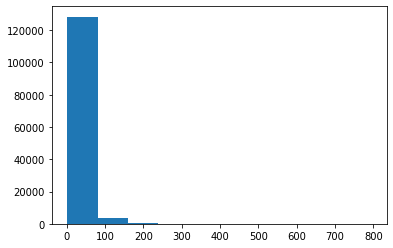

In [63]:
plt.hist([len(linha.split()) for linha in b2wCorpus["review_text"]])
plt.show()

In [76]:
#REF_MODEL = "bert-base-multilingual-cased"
REF_MODEL = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(REF_MODEL)

In [77]:
SEQUENCE_MAXLEN = 50

encoded_train = tokenizer(
    [[line] for line in x_train],
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQUENCE_MAXLEN,
    pad_to_max_length=True,
    return_tensors='np'
)

In [78]:
encoded_valid = tokenizer(
   [[line] for line in x_val],
    text_pair=None,
    is_split_into_words=True,
    padding="max_length",
    truncation=True,
    max_length=SEQUENCE_MAXLEN,
    pad_to_max_length=True,
    return_tensors='np'
)

In [79]:
encoded_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [80]:
encoded_train['input_ids'].shape

(92661, 50)

### Montando o modelo

Para montar o modelo, iremos utilizar a classe TFBertForSequenceClassification, do HuggingFace

Aqui tem um exemplo de código para vocês seguirem!


In [81]:
#bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
#input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_token', dtype='int32')
#input_masks_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='masked_token', dtype='int32')#

#X = bert_model(input_ids, input_masks_ids)

In [82]:
#model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
#model.summary()

In [83]:
#opt = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
#my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
#model.compile(opt, "sparse_categorical_crossentropy", metrics=["acc"])

In [84]:
#history = model.fit(
#    [encoded_text["input_ids"], encoded_text["attention_mask"]],
#    encoded_text_labels,
#    batch_size=32,
#    epochs=2,
#    callbacks=my_callbacks,
#)

## Treinando e avaliando seu modelo

###  <font color='blue'>Questão 4 </font>

Defina e treine seu modelo.

**Lembre-se de tambem adicionar os dados de validação do modelo**

In [85]:
bert_model = TFBertForSequenceClassification.from_pretrained(REF_MODEL, from_pt=True, num_labels=2)
input_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(SEQUENCE_MAXLEN,), name='masked_token', dtype='int32')

X = bert_model(input_ids, input_masks_ids)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the P

In [86]:
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

In [87]:
opt = tf.keras.optimizers.Adam()
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]
model.compile(opt, "sparse_categorical_crossentropy", metrics=["acc"])

In [89]:
history = model.fit(
    [encoded_train["input_ids"],
     encoded_train["attention_mask"]],
    y_train,
    batch_size=64,
    epochs=5,
    callbacks=my_callbacks,
    validation_data = ([encoded_valid["input_ids"],
                       encoded_valid["attention_mask"]],
                       y_val)
)    

Epoch 1/5
1448/1448 [==============================] - 1009s 697ms/step - loss: 0.6932 - acc: 0.7283 - val_loss: 0.6931 - val_acc: 0.7273
Epoch 2/5
1448/1448 [==============================] - 1013s 699ms/step - loss: 0.6932 - acc: 0.7283 - val_loss: 0.6931 - val_acc: 0.7273
Epoch 3/5
1448/1448 [==============================] - 1011s 698ms/step - loss: 0.6932 - acc: 0.7283 - val_loss: 0.6931 - val_acc: 0.7273
